In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import \
(KMeans,
AgglomerativeClustering)
from scipy.cluster.hierarchy import \
(dendrogram,
cut_tree)
from sklearn.model_selection import KFold, cross_val_score

In [7]:
data = pd.read_csv("revisedLoL_matchdata.csv")
#data = data.drop(['index'],axis=1)
data

,version https://git-lfs.github.com/spec/v1
0,oid sha256:158975141df8d1c77c15f8c933acd547342...
1,size 100527603


In [8]:
Xdata = data.drop(['game_id','winning_team'],axis=1)
Ydata = data['winning_team']

# CLUSTER K-MEANS

In [ ]:
# Preprocess the data
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(Xdata)

# Determine the number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [ ]:
# Choose the optimal number of clusters (e.g., 3)
optimal_clusters = 9
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
Xdata['Cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
Xdata['Cluster'].unique()

In [ ]:
game_state = {f'{i}': [] for i in range(9)}
for i in range(9):
    game_state[f'{i}'] = Xdata[Xdata['Cluster'] == i]

# CLASSIFICATION MODELING 

In [257]:
from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import random

## LOGISTIC REGRESSION

In [10]:
# Replace red team Id (200) with 0 and blue team Id with 1
Y = Ydata.replace([200,100],[0,1])
X = Xdata

# Split the data to training and testing set
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size = 0.7,random_state=1234)

### FIT WITH SCALE (ALSO DO CV NOW)

In [11]:
# Scale the features
scalerX = StandardScaler().fit(X)
X_scaled = scalerX.transform(X)

# Initialize K-Fold
k_folds = KFold(n_splits=5, shuffle = True, random_state = 123)

# Perform cross-validation
scores = cross_val_score(LogisticRegression(), X_scaled, Y, cv=k_folds, scoring = 'accuracy', n_jobs = -1)

print(scores,np.mean(scores))



[0.85134795 0.84336945 0.84912236 0.84996221 0.84992021] 0.8487444360460235


### We achieved a mean accuracy score of 84.9% with 5-fold CV using Logistic regression. One question: how is the prediction accuracy a function of game time? We would expect that earlier on in the game, the game state are relatively even and thus the result can swing any way. Thus it might be useful to see the prediction accuracy as a function of game time. Intuitively we would expect the prediction accuracy to increase as the game goes on.

In [12]:
# Split the game states into stages based on the game time.
# The game data was collected on a 3 minute interval, so we naturally have our stages.
print(len(X[X['in_game_time'] >= 40]))
print(len(X[X['in_game_time'] >= 43]))
print(len(X[X['in_game_time'] >= 45]))

# We will divide the stages into [10,13), [13,16) ... [40,43] and 45+

660
237
85


In [13]:
def myNull_accuracy(Y_test):
    null_accuracy = max(Y_test.value_counts())/len(Y_test)
    return null_accuracy
    

In [15]:
# Building my own k-fold CV to fit the use purpose
def mykCV(clf,X,Y,fold=5,scale = False):
    # We have 12 time intervals so make a np.array of size 12. THIS IS VERY CASE STUDY SPECIFIC
    score = np.zeros(12)
    game_stages_train_histogram = np.zeros(12)
    null_score = np.zeros(12)

    kf = KFold(n_splits = 5, shuffle = True, random_state = 123)
    if scale == True:
        scalerX = StandardScaler().fit(X)
        
        for train_index,test_index in kf.split(X):
            # Designate train/test set
            X_train, Y_train = X.loc[train_index], Y.loc[train_index]
            X_test, Y_test = X.loc[test_index], Y.loc[test_index]
    
            # Normalize the features
            X_train_scaled = scalerX.transform(X_train)
    
            # Fit
            clf.fit(X_train_scaled,Y_train)
    
            # Divide the test set based on in_game_time
            # Dictionary, keyword is a time interval, i.e [10,13) and contain all the game states in that time interval
            game_stages = {f'[{i},{i+3})': X_test[(X_test['in_game_time'] >= i) & (X_test['in_game_time'] < i+3)] for i in range(10,43,3)}
            game_stages['45+'] = X_test[X_test['in_game_time'] >= 45]

            game_stages_result = {f'[{i},{i+3})': Y[game_stages[f'[{i},{i+3})'].index] for i in range(10,43,3)}
            game_stages_result['45+'] = Y[game_stages['45+'].index]

            # Compute the classification accuracy for each stages of the game
            accuracy = np.array([accuracy_score(game_stages_result[f'[{i},{i+3})'], 
                         clf.predict(scalerX.transform(game_stages[f'[{i},{i+3})']))) for i in range(10,43,3)])
            accuracy = np.append(accuracy, accuracy_score(game_stages_result['45+'], clf.predict(scalerX.transform(game_stages['45+']))))
            score += accuracy
            
            # Compute the null accuracy for each stages of the game
            null_accuracy = np.array([myNull_accuracy(game_stages_result[f'[{i},{i+3})']) for i in range(10,43,3)])
            null_accuracy = np.append(null_accuracy,myNull_accuracy((game_stages_result['45+'])))
            null_score += null_accuracy
            
            #compute the distribution of game stages
            game_stages_train = {f'[{i},{i+3})': X_train[(X_train['in_game_time'] >= i) & (X_train['in_game_time'] < i+3)] for i in range(10,43,3)}
            game_stages_train['45+'] = X_train[X_train['in_game_time'] >= 45]
            
            game_stages_train_histogram += np.array([len(game_stages_train[f'[{i},{i+3})']) for i in range(10,43,3)] + [len(game_stages_train['45+'])])
    else:
        for train_index,test_index in kf.split(X):
            # Designate train/test set
            X_train, Y_train = X.loc[train_index], Y.loc[train_index]
            X_test, Y_test = X.loc[test_index], Y.loc[test_index]
            
            # Fit
            clf.fit(X_train,Y_train)
    
            # Divide the test set based on in_game_time
            game_stages = {f'[{i},{i+3})': X_test[(X_test['in_game_time'] >= i) & (X_test['in_game_time'] < i+3)] for i in range(10,43,3)}
            game_stages['45+'] = X_test[X_test['in_game_time'] >= 45]
    
            game_stages_result = {f'[{i},{i+3})': Y[game_stages[f'[{i},{i+3})'].index] for i in range(10,43,3)}
            game_stages_result['45+'] = Y[game_stages['45+'].index]

            # Compute the accuracy score for each stages of the game
            accuracy = np.array([accuracy_score(game_stages_result[f'[{i},{i+3})'], 
                         clf.predict(game_stages[f'[{i},{i+3})'])) for i in range(10,43,3)])
            accuracy = np.append(accuracy, accuracy_score(game_stages_result['45+'], clf.predict(game_stages['45+'])))
            score += accuracy

            # Compute the null accuracy score for each stages of the game
            null_accuracy = np.array([myNull_accuracy(game_stages_result[f'[{i},{i+3})']) for i in range(10,43,3)])
            null_accuracy = np.append(null_accuracy,myNull_accuracy((game_stages_result['45+'])))
            null_score += null_accuracy
            
            #compute the distribution of game stages
            game_stages_train = {f'[{i},{i+3})': X_train[(X_train['in_game_time'] >= i) & (X_train['in_game_time'] < i+3)] for i in range(10,43,3)}
            game_stages_train['45+'] = X_train[X_train['in_game_time'] >= 45]  
            game_stages_train_histogram += np.array([len(game_stages_train[f'[{i},{i+3})']) for i in range(10,43,3)] + [len(game_stages_train['45+'])])
    
    score /= fold
    null_score /= fold
    game_stages_train_histogram = game_stages_train_histogram / np.sum(game_stages_train_histogram)
    return score, null_score, game_stages_train_histogram

In [16]:
# Plotting the mean k-CV score as a function of time in the game
x_axis = np.array([f'[{i},{i+3})' for i in range(10,43,3)])
x_axis = np.append(x_axis,'45+')

y_axis,y_null_axis,y_histogram = mykCV(LogisticRegression(),X,Y,scale=True)

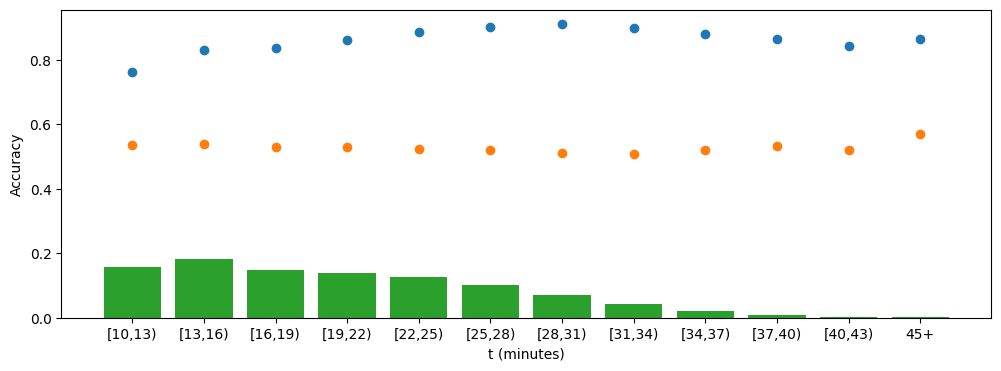

In [17]:
fig = plt.figure()
fig.set_size_inches(12,4)
plt.scatter(x_axis,y_axis)
plt.scatter(x_axis,y_null_axis)
plt.bar(x_axis,y_histogram)
plt.xlabel('t (minutes)')
plt.ylabel('Accuracy')
plt.show(fig)

### We see that the accuracy score does increase as a function of the in game time. However, there are notable features. First, we see that there is a peak at the time interval [13,16). This is possibly due to the 'ff' (surrender) aspect of the game being enabled at 15. There is also another peak at [28,31). The peak at [28,31) could be due to the fact that in later game stages, the relative power between champions start to diminish due to: level cap, increased experience to level, item breakpoints. Specifically, in later game stages, long death timer can lead to one team destroying the nexus after one team fight. All of this lead to decreasing predictive power. 

### Furthermore, this decrease in predictive power can just be an artifact of training sample size. The distribution of game sizes are naturally skewed to shorter games.


## RANDOM FOREST

In [14]:
# Initialize K-Fold
k_folds = KFold(n_splits=5, shuffle = True, random_state = 123)

# Perform cross-validation
scores = cross_val_score(RandomForestClassifier(), X, Y, cv=k_folds, scoring = 'accuracy', n_jobs = -1)

print(scores,np.mean(scores))

[0.85802469 0.85260771 0.85605106 0.85718485 0.85546317] 0.8558662971361384


In [15]:
y_axis_RF,y_null_axis_RF, y_histogram_RF = mykCV(RandomForestClassifier(), X, Y)

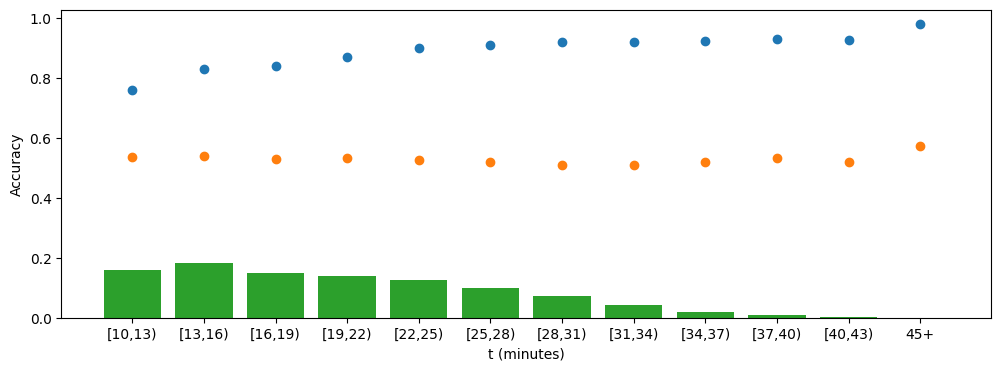

In [16]:
fig_RF = plt.figure()
fig_RF.set_size_inches(12,4)
plt.scatter(x_axis,y_axis_RF)
plt.scatter(x_axis,y_null_axis_RF)
plt.bar(x_axis,y_histogram_RF)
plt.xlabel('t (minutes)')
plt.ylabel('Accuracy')
plt.show(fig)

## RELIABILITY

In [133]:
def ECE_compute(y_pred,prob_pred,prob_true,num_bins=10):
    ECE_score = 0
    for bin in range(num_bins):
        ECE_score += len(y_pred[(y_pred >= bin/num_bins) & (y_pred < (bin+1)/num_bins)]) * abs(prob_true[bin] - prob_pred[bin])
    return ECE_score/len(y_pred)

In [255]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size = 0.7,random_state=1234)

scalerX = StandardScaler().fit(X)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

### Logistic Regression

In [ ]:
# Train a Logistic regression
lr = LogisticRegression()
lr.fit(X_train_scaled, Y_train)

In [134]:
test_set = pd.concat([Y_test,X_test],axis=1)

game_stages = {f'[{i},{i+3})': test_set[(test_set['in_game_time'] >= i) & (test_set['in_game_time'] < i+3)] for i in range(10,40,3)}
game_stages['40+'] = test_set[test_set['in_game_time'] >= 40]

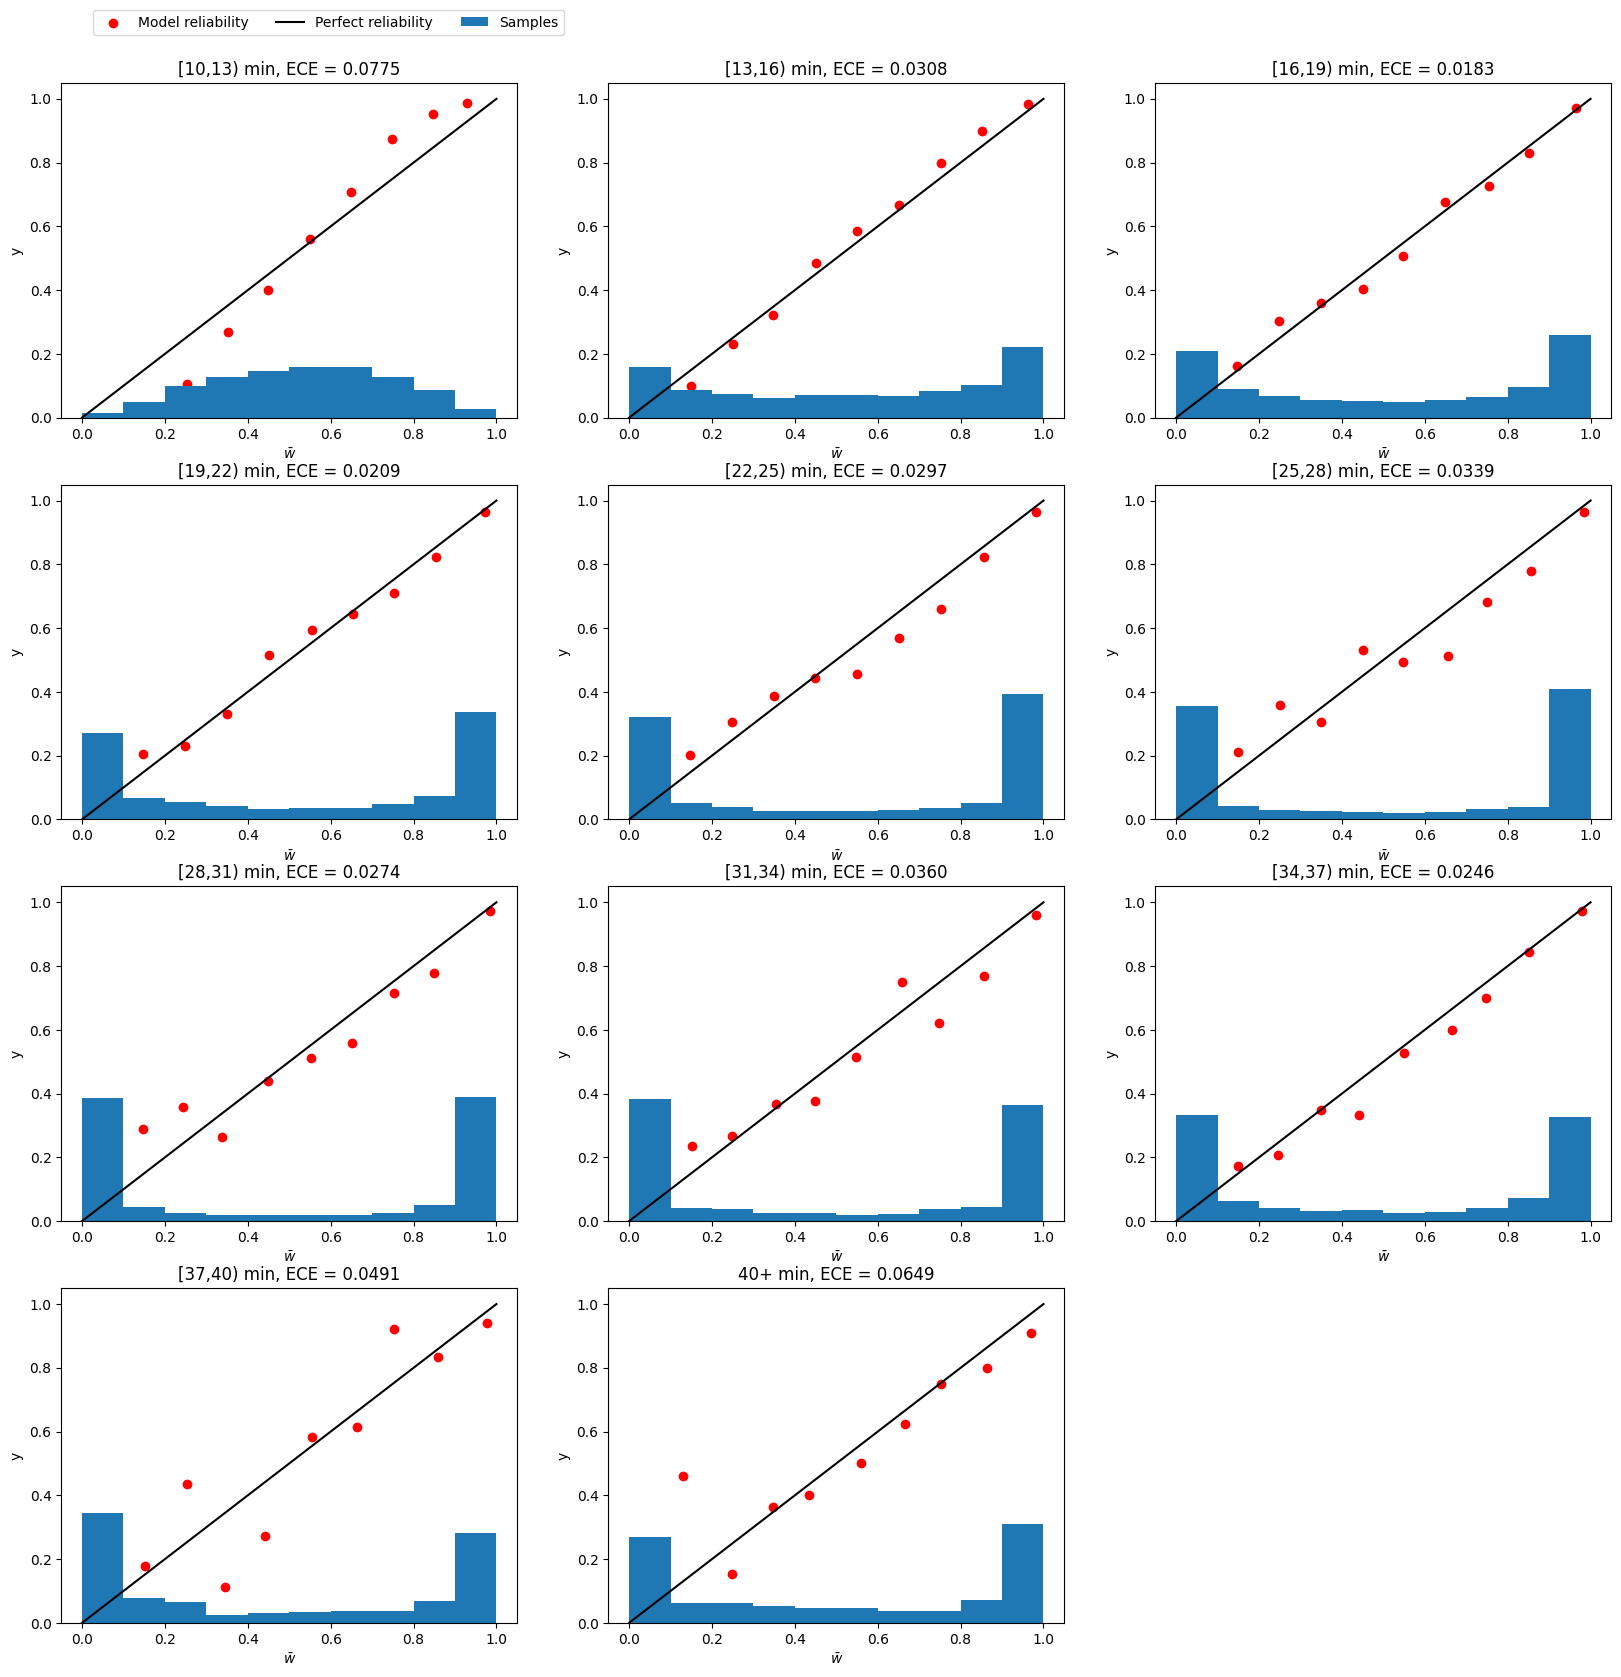

In [254]:
# Create a figure with 12 subplots
fig, ax = plt.subplots(4,3)

#Set appropriate size for figure
fig.set_size_inches(20, 20)

x = np.linspace(0,1)
y = x

# Indicator to loop through the predictors in Boston 
i,j = 0,0

for time_interval in game_stages:
    # First column = % belong to class 0
    X_test = game_stages[time_interval].drop(['winning_team'],axis=1)
    Y_test = game_stages[time_interval]['winning_team']
    y_true = Y_test
    y_pred = lr.predict_proba(scalerX.transform(X_test))[:,1] 
    prob_true, prob_pred = calibration_curve(y_true,y_pred,n_bins = 10)
    ECE_score = ECE_compute(y_pred,prob_pred,prob_true)
    
    ax[i,j].scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
    ax[i,j].plot(x,y,color='black', label = 'Perfect reliability')
    ax[i,j].set_title(f'{time_interval} min, ECE = {ECE_score:.4f}')
    ax[i,j].set_xlabel(r'$\bar{w}$')
    ax[i,j].set_ylabel(r'y')

    count,bins = np.histogram(y_pred,range=[0,1],bins=10)
    ax[i,j].hist(bins[:-1], bins, weights=count/np.sum(count),label='Samples')

    if j < 2: 
        j += 1
    else:
        i += 1
        j = 0

lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=3,bbox_to_anchor=(0.38, 0.92))
fig.delaxes(ax[3,2])
plt.show()

### Random Forest

In [259]:
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)

RandomForestClassifier()

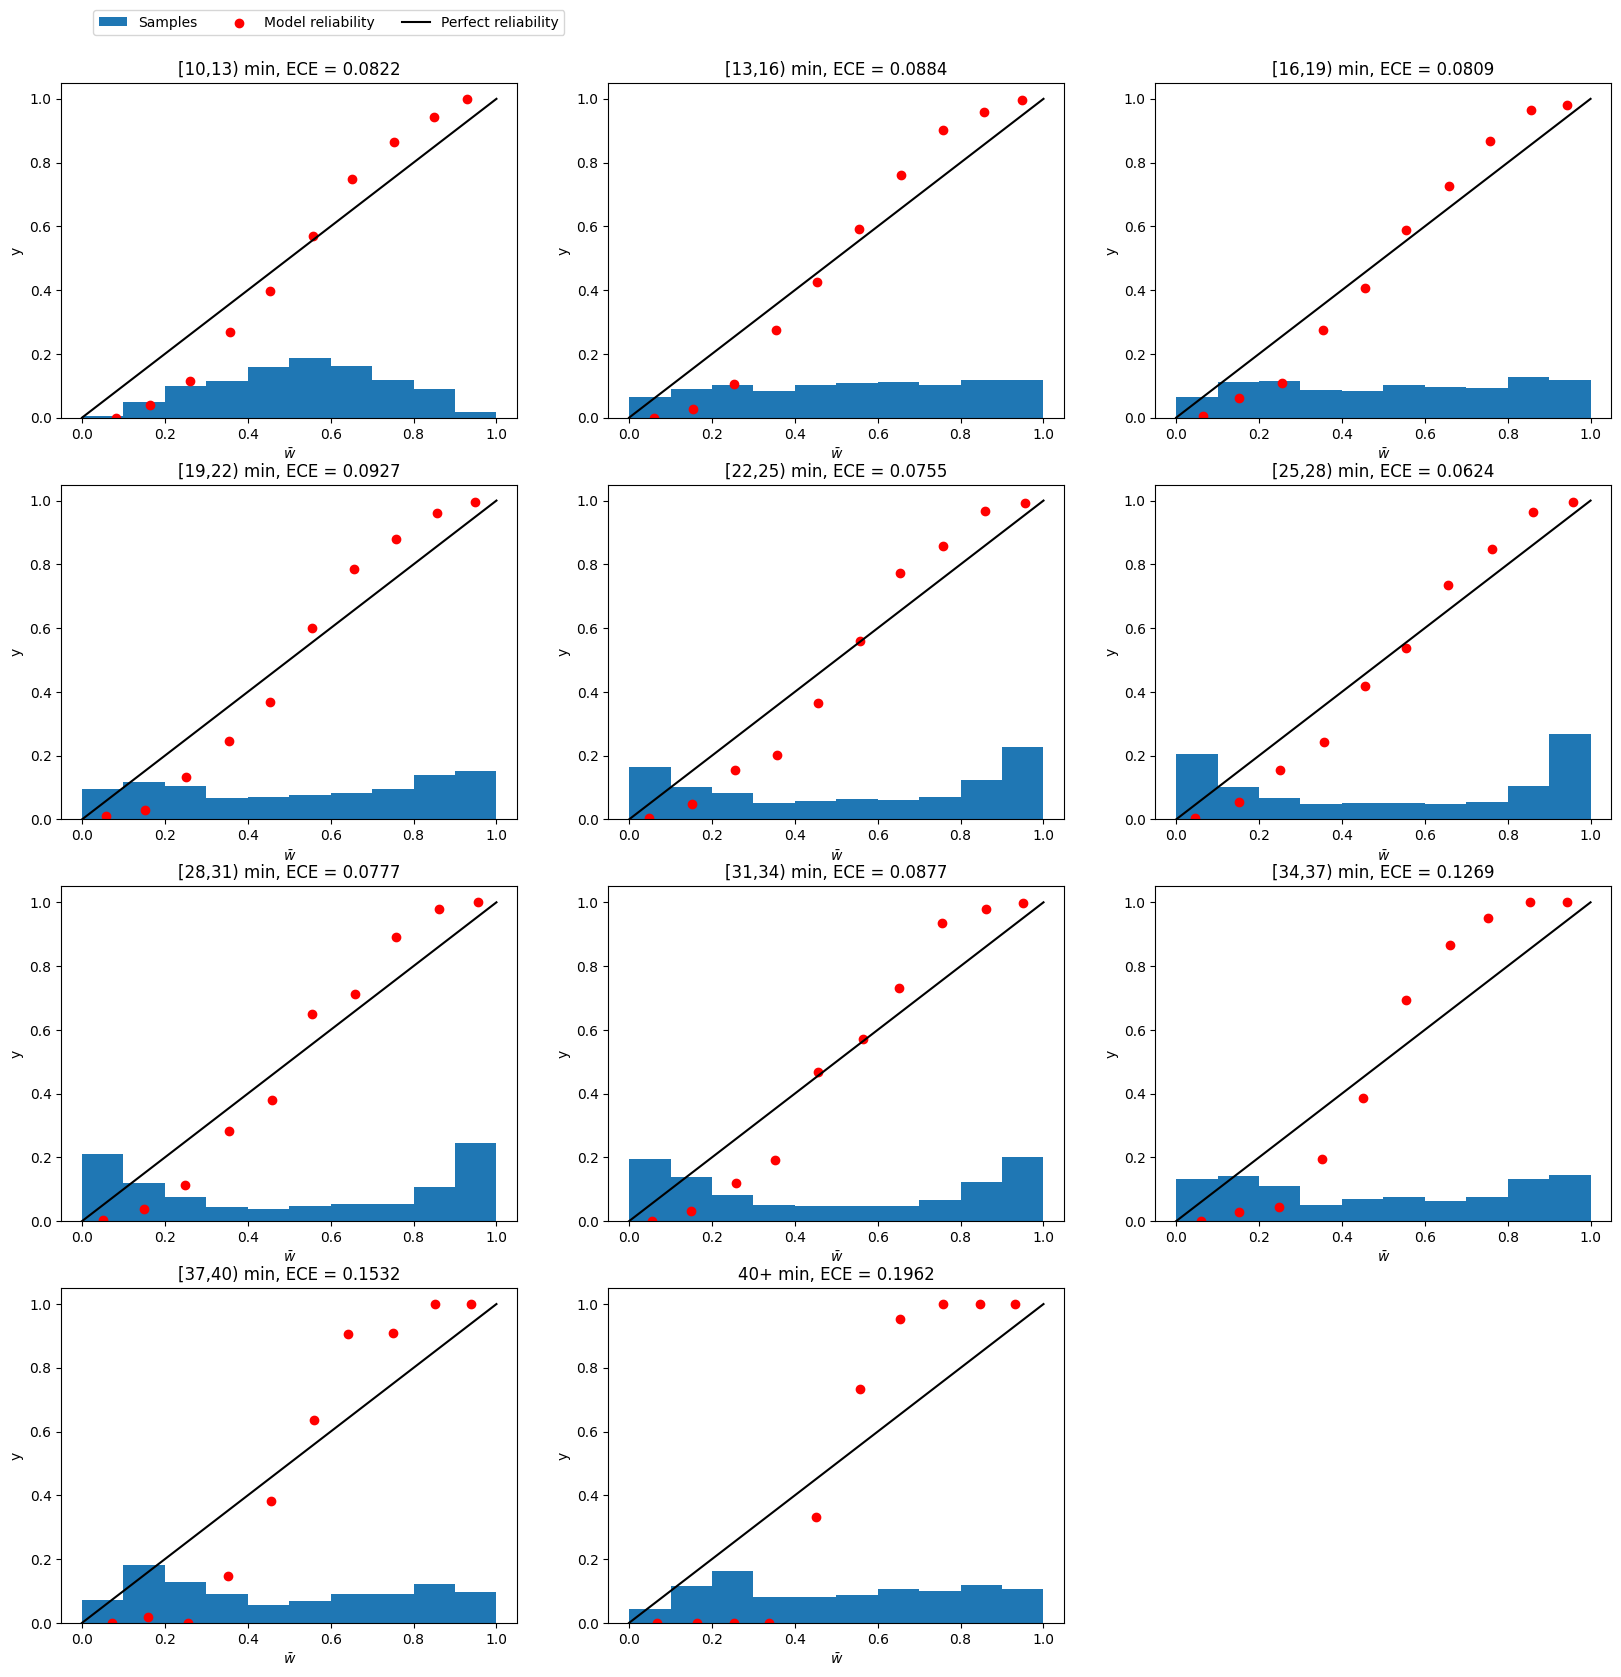

In [261]:
# Create a figure with 12 subplots
fig, ax = plt.subplots(4,3)

#Set appropriate size for figure
fig.set_size_inches(20, 20)

x = np.linspace(0,1)
y = x

# Indicator to loop through the predictors in Boston 
i,j = 0,0

for time_interval in game_stages:
    # First column = % belong to class 0
    X_test = game_stages[time_interval].drop(['winning_team'],axis=1)
    Y_test = game_stages[time_interval]['winning_team']
    y_true = Y_test
    y_pred = rf.predict_proba(X_test)[:,1] 
    prob_true, prob_pred = calibration_curve(y_true,y_pred,n_bins = 10)
    ECE_score = ECE_compute(y_pred,prob_pred,prob_true)

    count,bins = np.histogram(y_pred,range=[0,1],bins=10)
    ax[i,j].hist(bins[:-1], bins, weights=count/np.sum(count),label='Samples')
    ax[i,j].scatter(prob_pred,prob_true,color='r',label = 'Model reliability')
    ax[i,j].plot(x,y,color='black', label = 'Perfect reliability')
    ax[i,j].set_title(f'{time_interval} min, ECE = {ECE_score:.4f}')
    ax[i,j].set_xlabel(r'$\bar{w}$')
    ax[i,j].set_ylabel(r'y')

    if j < 2: 
        j += 1
    else:
        i += 1
        j = 0

lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=3,bbox_to_anchor=(0.38, 0.92))
fig.delaxes(ax[3,2])
plt.show()

In [267]:
X_test = game_stages['40+'].drop(['winning_team'],axis=1)
Y_test = game_stages['40+']['winning_team']
y_true = Y_test
y_pred = rf.predict_proba(X_test)[:,1]

accuracy_score(y_true,rf.predict(X_test))

0.9473684210526315

In [263]:
rf.predict(X_test)

array([1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0.])

In [280]:
ahh = y_true.to_numpy()
ahh

array([1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0.])

In [ ]:
[:,1] 
prob_true, prob_pred = calibration_curve(y_true,y_pred,n_bins = 10)
ECE_score = ECE_compute(y_pred,prob_pred,prob_true)